In [51]:
#importing required packages
#modelues for EDA steps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modules for data cleaning and data analysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

#modules for model building
#algorithms for sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#baseline linear model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#modules for hyper parameter tuning
from sklearn.model_selection import GridSearchCV

#modules for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, accuracy_score, f1_score, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve

#modules for avoiding warnings
import warnings
warnings.filterwarnings('ignore')

#setting backend for matplotlib
%matplotlib inline

#setting formatting options
pd.options.display.max_columns = 100
pd.options.display.max_rows = 900
pd.set_option('float_format' , '{:f}'.format)

#setting plot style
plt.style.use('seaborn-darkgrid')

In [52]:
#loading the dataset
df = pd.read_csv('data/fraudTrain.csv')

In [53]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [54]:
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [55]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [56]:
df.drop('Unnamed: 0', axis=1, inplace=True)

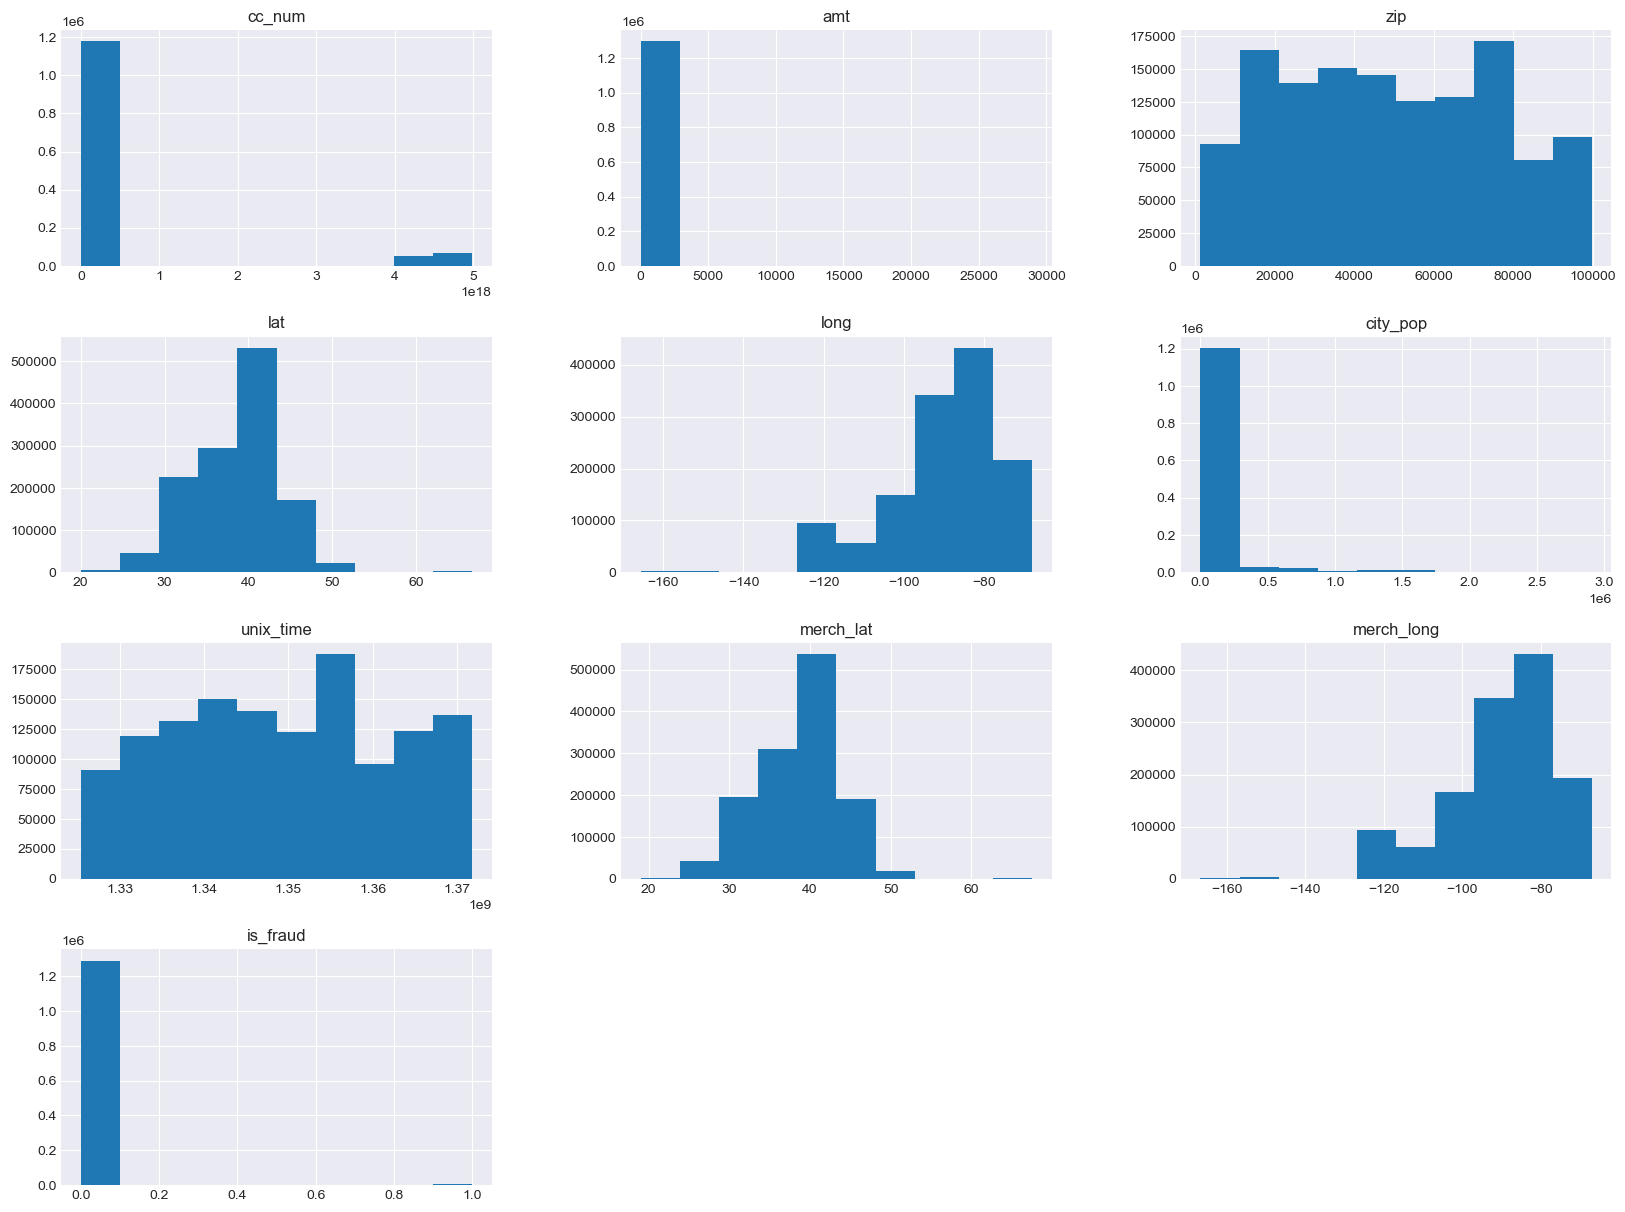

In [57]:
# Plot the distribution of each variable
df.hist(figsize=(20,15))
plt.show()

In [58]:
# Check the class balance of the target variable
print(df['is_fraud'].value_counts())

0    1289169
1       7506
Name: is_fraud, dtype: int64


In [59]:
# Analyze the transaction patterns of the customers
grouped_data = df.groupby(['cc_num', 'merchant', 'category'])
grouped_data.size().reset_index(name='count')

,cc_num,merchant,category,count
0,60416207185,fraud_Abbott-Rogahn,entertainment,3
1,60416207185,fraud_Abbott-Steuber,personal_care,4
2,60416207185,fraud_Abernathy and Sons,food_dining,3
3,60416207185,fraud_Abshire PLC,entertainment,2
4,60416207185,"fraud_Adams, Kovacek and Kuhlman",grocery_net,2
...,...,...,...,...
482872,4992346398065154184,fraud_Zemlak Group,misc_net,3
482873,4992346398065154184,"fraud_Zemlak, Tillman and Cremin",personal_care,4
482874,4992346398065154184,fraud_Ziemann-Waters,health_fitness,4
482875,4992346398065154184,"fraud_Zieme, Bode and Dooley",gas_transport,8


In [60]:
# Feature engineering
# Extract useful information from the "trans_date_trans_time" variable
#converting trans_date_trans_time into datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'])
df['day_of_week'] = df['trans_datetime'].dt.dayofweek
df['hour_of_day'] = df['trans_datetime'].dt.hour
df['trans_year_month'] = df['trans_date_trans_time'].dt.to_period('M')
df['time_since_last_trans'] = df.groupby(['cc_num'])['unix_time'].diff().fillna(0)

In [61]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_datetime,day_of_week,hour_of_day,trans_year_month,time_since_last_trans
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01 00:00:18,1,0,2019-01,0.000000
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44,1,0,2019-01,0.000000
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01 00:00:51,1,0,2019-01,0.000000
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01 00:01:16,1,0,2019-01,0.000000
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01 00:03:06,1,0,2019-01,0.000000


In [62]:
# Create a new variable that indicates the distance between the customer's location and the merchant's location
df['dist_customer_merchant'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

In [13]:
# Create a new variable that indicates the frequency of transactions made by each customer at each merchant
df['freq_trans_customer_merchant'] = df.groupby(['cc_num', 'merchant'])['trans_num'].transform('count')

# Create a new variable that indicates the time difference between the current transaction and the previous transaction made by the same customer at the same merchant
df['time_diff_customer_merchant'] = df.groupby(['cc_num', 'merchant'])['unix_time'].diff().fillna(0)

In [63]:
#finding age
#converting 'dob' column to datetime
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = np.round((df['trans_date_trans_time'] - df['dob'])/np.timedelta64(1, 'Y'))
df.age.head()

0   31.000000
1   41.000000
2   57.000000
3   52.000000
4   33.000000
Name: age, dtype: float64

In [64]:
#dropping variables
df.drop(['trans_date_trans_time','first', 'last', 'dob'] , axis=1, inplace=True)
df.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_datetime,day_of_week,hour_of_day,trans_year_month,time_since_last_trans,dist_customer_merchant,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01 00:00:18,1,0,2019-01,0.000000,0.872830,31.000000
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44,1,0,2019-01,0.000000,0.272310,41.000000
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01 00:00:51,1,0,2019-01,0.000000,0.975845,57.000000
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01 00:01:16,1,0,2019-01,0.000000,0.919802,52.000000
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01 00:03:06,1,0,2019-01,0.000000,0.868505,33.000000


In [65]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,day_of_week,hour_of_day,time_since_last_trans,dist_customer_merchant,age
count,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000,1296675.000000
mean,417192042079641088.000000,70.351035,48800.671097,38.537622,-90.226335,88824.440563,1349243636.726123,38.537338,-90.226465,0.005789,3.070604,12.804858,32460.388633,0.765661,45.999860
std,1308806447000789248.000000,160.316039,26893.222476,5.075808,13.759077,301956.360689,12841278.423360,5.109788,13.771091,0.075863,2.198153,6.817824,47331.144692,0.284748,17.396256
min,60416207185.000000,1.000000,1257.000000,20.027100,-165.672300,23.000000,1325376018.000000,19.027785,-166.671242,0.000000,0.000000,0.000000,0.000000,0.000239,14.000000
25%,180042946491150.000000,9.650000,26237.000000,34.620500,-96.798000,743.000000,1338750742.500000,34.733572,-96.897276,0.000000,1.000000,7.000000,6004.000000,0.564958,33.000000
50%,3521417320836166.000000,47.520000,48174.000000,39.354300,-87.476900,2456.000000,1349249747.000000,39.365680,-87.438392,0.000000,3.000000,14.000000,16563.000000,0.798311,44.000000
75%,4642255475285942.000000,83.140000,72042.000000,41.940400,-80.158000,20328.000000,1359385375.500000,41.957164,-80.236796,0.000000,5.000000,19.000000,40239.000000,0.977536,57.000000
max,4992346398065154048.000000,28948.900000,99783.000000,66.693300,-67.950300,2906700.000000,1371816817.000000,67.510267,-66.950902,1.000000,6.000000,23.000000,1341471.000000,1.413364,96.000000


In [66]:
#let us check the percentage of fraudulent data points in our dataset
100*df.is_fraud.value_counts(normalize=True)

0   99.421135
1    0.578865
Name: is_fraud, dtype: float64

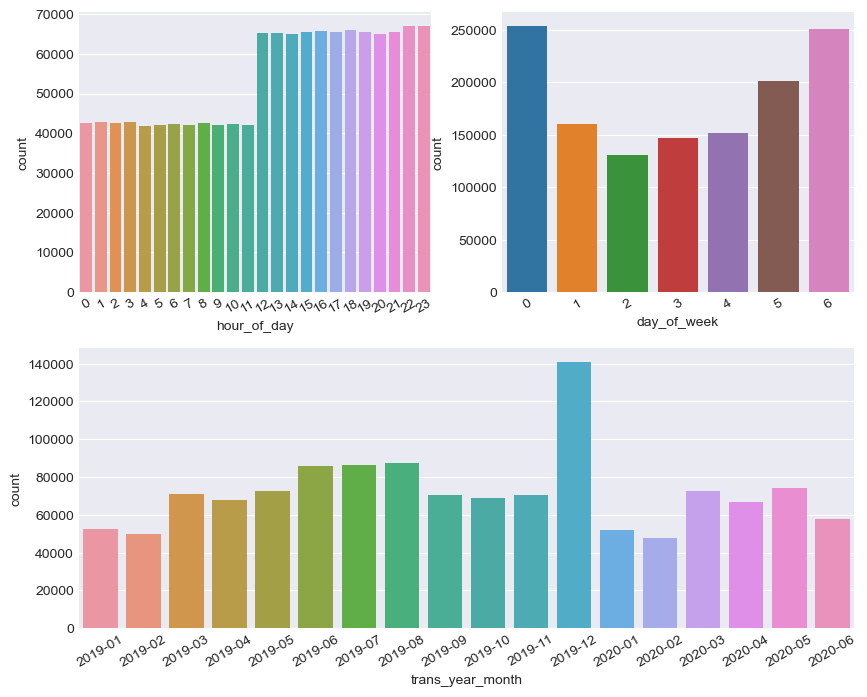

In [67]:
fix, ax = plt.subplots(figsize=(10,8))

plot = [0,0,0]
#plotting the 'trans_hour' feature
plot[0] = sns.countplot(df.hour_of_day, ax = plt.subplot(221))
#plotting the 'trans_day_of_week' feature
plot[1] = sns.countplot(df.day_of_week, ax = plt.subplot(222))
#plotting the 'trans_year_month' feature
plot[2] = sns.countplot(df.trans_year_month, ax = plt.subplot(212))

for i in plot:
  i.set_xticklabels(i.get_xticklabels(), rotation=30)
plt.show()

In [68]:
#year_month vs number of transactions
df_timeline1 = df.groupby(df['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_timeline1.columns = ['year_month','num_of_transactions','customers']
df_timeline1

,year_month,num_of_transactions,customers
0,2019-01,52525,913
1,2019-02,49866,918
2,2019-03,70939,916
3,2019-04,68078,913
4,2019-05,72532,910
5,2019-06,86064,908
6,2019-07,86596,910
7,2019-08,87359,911
8,2019-09,70652,913
9,2019-10,68758,912


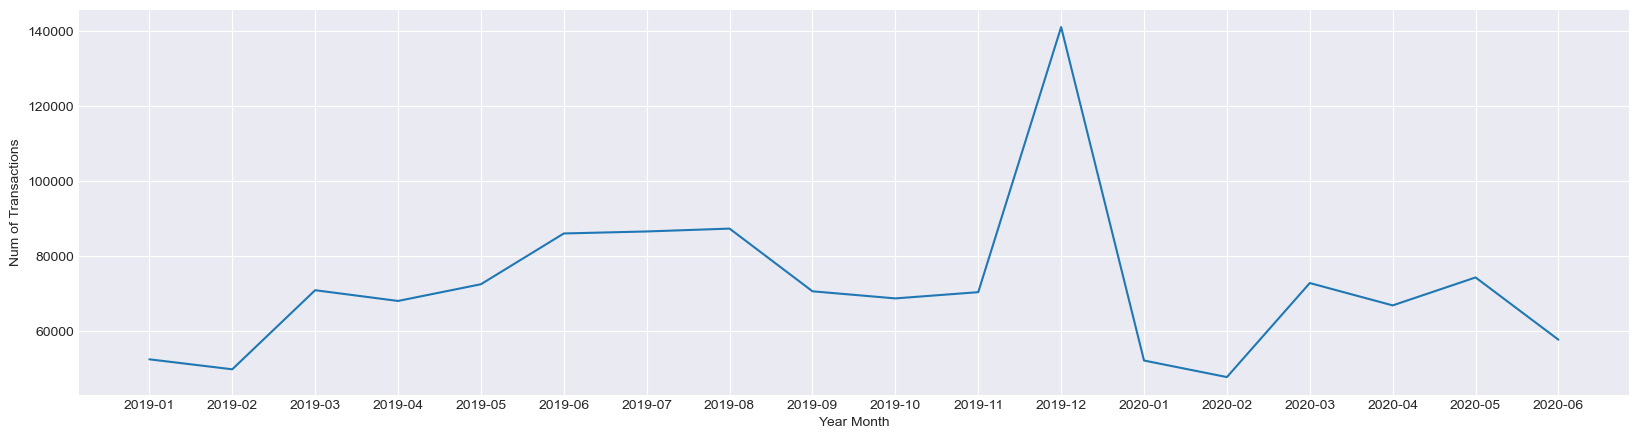

In [69]:
x = np.arange(0,len(df_timeline1),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_timeline1['num_of_transactions'])
ax.set_xticks(x)
ax.set_xticklabels(df_timeline1['year_month'])

ax.set_xlabel('Year Month')
ax.set_ylabel('Num of Transactions')
plt.show()

In [70]:
df_fraud_transactions = df[df['is_fraud']==1]

df_timeline2 = df_fraud_transactions.groupby(df_fraud_transactions['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_timeline2.columns = ['year_month','num_of_fraud_transactions','fraud_customers']
df_timeline2

,year_month,num_of_fraud_transactions,fraud_customers
0,2019-01,506,50
1,2019-02,517,53
2,2019-03,494,49
3,2019-04,376,41
4,2019-05,408,42
5,2019-06,354,35
6,2019-07,331,36
7,2019-08,382,39
8,2019-09,418,44
9,2019-10,454,50


In [71]:
new_timeline_df = pd.merge(df_timeline1, df_timeline2, on='year_month', how='inner')

In [72]:
new_timeline_df.head()

,year_month,num_of_transactions,customers,num_of_fraud_transactions,fraud_customers
0,2019-01,52525,913,506,50
1,2019-02,49866,918,517,53
2,2019-03,70939,916,494,49
3,2019-04,68078,913,376,41
4,2019-05,72532,910,408,42


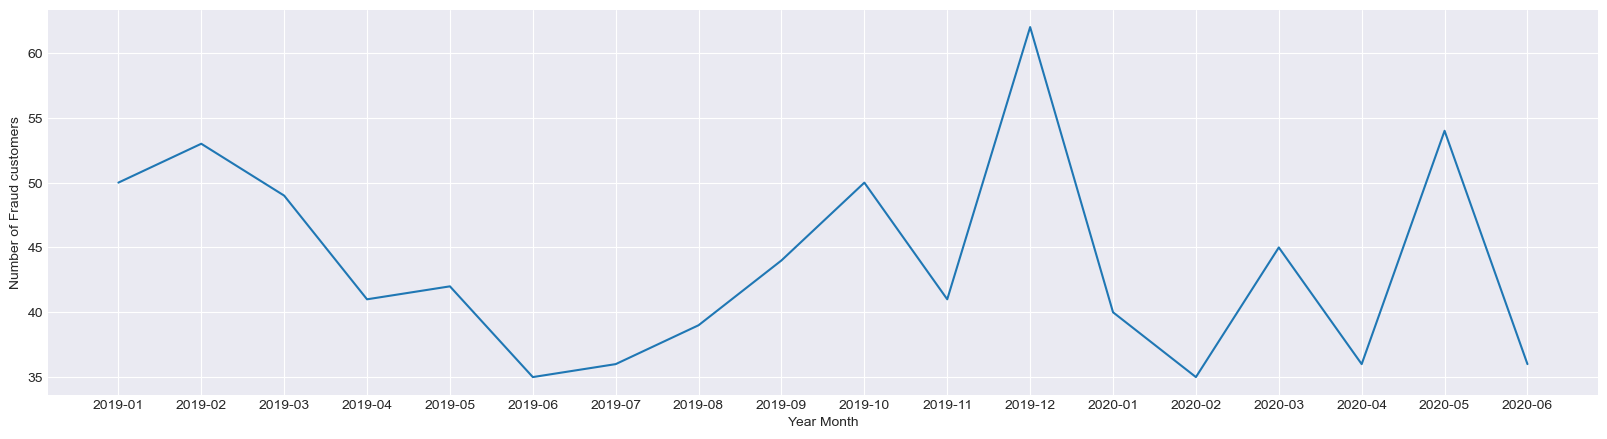

In [73]:
x = np.arange(0,len(df_timeline2),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_timeline2['fraud_customers'])
ax.set_xticks(x)
ax.set_xticklabels(df_timeline2['year_month'])

ax.set_xlabel('Year Month')
ax.set_ylabel('Number of Fraud customers')
plt.show()

In [74]:
#creating the 'gender' distributed dataframe
df_gender = df[['gender','trans_num']].groupby(['gender']).count().reset_index()
df_gender.columns = ['Gender', 'gender_count']

#creating gender-fraud distribution
df_fraud_gender = df[['gender','trans_num', 'is_fraud']].groupby(['gender','is_fraud']).count().reset_index()
df_fraud_gender.columns = ['Gender', 'is_fraud', 'Transaction Count']

df_fraud_gender = df_fraud_gender.merge(df_gender[['Gender', 'gender_count']], how='inner', on='Gender')

df_fraud_gender['Transaction percentage'] = (df_fraud_gender['Transaction Count']/df_fraud_gender['gender_count'])*100

df_fraud_gender

,Gender,is_fraud,Transaction Count,gender_count,Transaction percentage
0,F,0,706128,709863,99.473842
1,F,1,3735,709863,0.526158
2,M,0,583041,586812,99.357375
3,M,1,3771,586812,0.642625


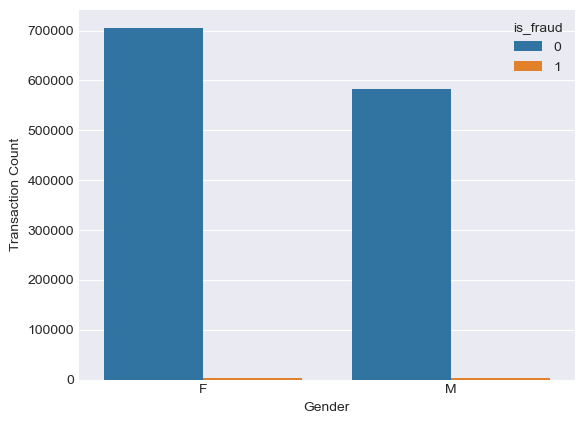

In [75]:
sns.barplot(data=df_fraud_gender, y='Transaction Count', x='Gender', hue='is_fraud')

plt.show()

In [76]:
#let us first bin the age feature
for i in range(len(df.age)):
  if df.age[i] <= 30:
    df.age[i] = '< 30'
  elif df.age[i] > 30 and df.age[i] <= 45:
    df.age[i] = '30-45'
  elif df.age[i] > 45 and df.age[i] <= 60:
    df.age[i] = '46-60'
  elif df.age[i] > 60 and df.age[i] <= 75:
    df.age[i] = '61-75'
  else:
    df.age[i] = '> 75'

df.age.head()

0    30-45
1    30-45
2    46-60
3    46-60
4    30-45
Name: age, dtype: object

In [77]:
#constructing the age-transaction count distribution
df_age = df[['age','trans_num']].groupby(['age']).count().reset_index()
df_age.columns = ['age', 'age_count']

#creating the age-fraud distribution
df_fraud_age = df[['age', 'trans_num', 'is_fraud']].groupby(['age','is_fraud']).count().reset_index()
df_fraud_age.columns = ['age', 'is_fraud', 'Transaction count']

df_fraud_age = df_fraud_age.merge(df_age[['age', 'age_count']], how='inner', on='age')

df_fraud_age['Transaction percentage'] = (df_fraud_age['Transaction count']/df_fraud_age['age_count'])*100

df_fraud_age

,age,is_fraud,Transaction count,age_count,Transaction percentage
0,30-45,0,438557,440411,99.579030
1,30-45,1,1854,440411,0.420970
2,46-60,0,334647,336814,99.356618
3,46-60,1,2167,336814,0.643382
4,61-75,0,170800,171904,99.357781
5,61-75,1,1104,171904,0.642219
6,< 30,0,255220,256759,99.400605
7,< 30,1,1539,256759,0.599395
8,> 75,0,89945,90787,99.072554
9,> 75,1,842,90787,0.927446


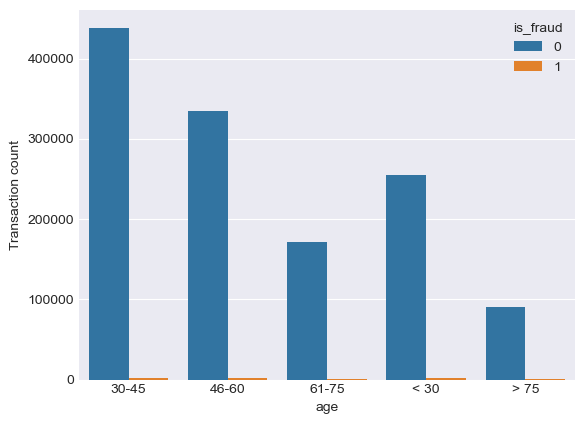

In [78]:
sns.barplot(data=df_fraud_age, y='Transaction count', x='age', hue='is_fraud')

plt.show()

In [79]:
#constructing the zip-transaction count distribution
df_job = df[['job','trans_num']].groupby(['job']).count().reset_index()
df_job.columns = ['job', 'job_count']

#creating the zip-fraud distribution
df_fraud_job = df[['job', 'trans_num', 'is_fraud']].groupby(['job','is_fraud']).count().reset_index()
df_fraud_job.columns = ['job', 'is_fraud', 'Transaction count']

df_fraud_job = df_fraud_job.merge(df_job[['job', 'job_count']], how='inner', on='job')

df_fraud_job['Transaction percentage'] = (df_fraud_job['Transaction count']/df_fraud_job['job_count'])*100

#viewing the top 20 jobs with high fraudulent transaction volumes
df_fraud_job[df_fraud_job['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,job,is_fraud,Transaction count,job_count,Transaction percentage
64,Armed forces technical officer,1,8,8,100.000000
318,"Engineer, site",1,12,12,100.000000
453,Information officer,1,8,8,100.000000
493,Legal secretary,1,12,12,100.000000
450,Industrial buyer,1,10,10,100.000000
111,Careers adviser,1,15,15,100.000000
421,Homeopath,1,11,11,100.000000
94,Broadcast journalist,1,9,9,100.000000
619,Personnel officer,1,12,12,100.000000
374,Forest/woodland manager,1,9,9,100.000000


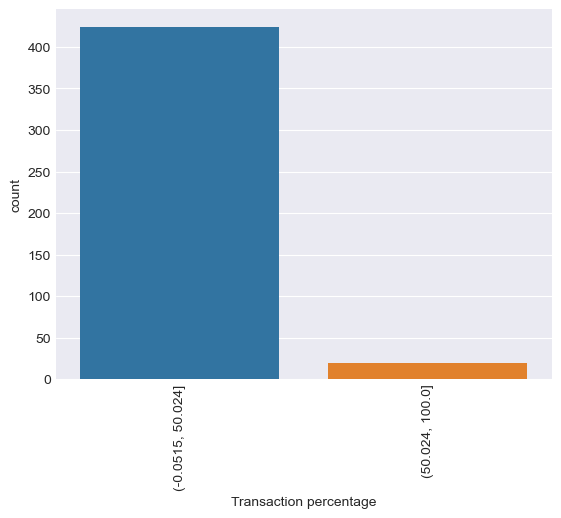

In [80]:
#plotting the fraudulent transactions percentage by binning
plot = sns.countplot(pd.cut(df_fraud_job[df_fraud_job.is_fraud == 1]['Transaction percentage'], bins = 2))
plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
plt.show()

In [81]:
#job with more than one percent fraudulent transactions
df_fraud_job.loc[(df_fraud_job.is_fraud == 1) & (df_fraud_job['Transaction percentage'] >= 50)].job

2                  Accountant, chartered
39                Air traffic controller
64        Armed forces technical officer
94                  Broadcast journalist
111                      Careers adviser
198           Contracting civil engineer
218                               Dancer
318                       Engineer, site
374              Forest/woodland manager
421                            Homeopath
450                     Industrial buyer
453                  Information officer
493                      Legal secretary
619                    Personnel officer
758    Sales promotion account executive
787                          Ship broker
795                            Solicitor
898                   Veterinary surgeon
906                    Warehouse manager
Name: job, dtype: object

In [82]:
df.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_datetime,day_of_week,hour_of_day,trans_year_month,time_since_last_trans,dist_customer_merchant,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01 00:00:18,1,0,2019-01,0.000000,0.872830,30-45
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44,1,0,2019-01,0.000000,0.272310,30-45
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01 00:00:51,1,0,2019-01,0.000000,0.975845,46-60
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01 00:01:16,1,0,2019-01,0.000000,0.919802,46-60
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01 00:03:06,1,0,2019-01,0.000000,0.868505,30-45


In [83]:
# Encode the categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['category'] = label_encoder.fit_transform(df['category'])
df['age'] = label_encoder.fit_transform(df['age'])

In [84]:
df.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_datetime,day_of_week,hour_of_day,trans_year_month,time_since_last_trans,dist_customer_merchant,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",8,4.970000,0,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01 00:00:18,1,0,2019-01,0.000000,0.872830,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",4,107.230000,0,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44,1,0,2019-01,0.000000,0.272310,0
2,38859492057661,fraud_Lind-Buckridge,0,220.110000,1,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01 00:00:51,1,0,2019-01,0.000000,0.975845,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",2,45.000000,1,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01 00:01:16,1,0,2019-01,0.000000,0.919802,1
4,375534208663984,fraud_Keeling-Crist,9,41.960000,1,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01 00:03:06,1,0,2019-01,0.000000,0.868505,0


In [85]:
df.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'trans_datetime',
       'day_of_week', 'hour_of_day', 'trans_year_month',
       'time_since_last_trans', 'dist_customer_merchant', 'age'],
      dtype='object')

In [86]:
df.drop([ 'cc_num','street','city','state','job'], axis=1, inplace=True)

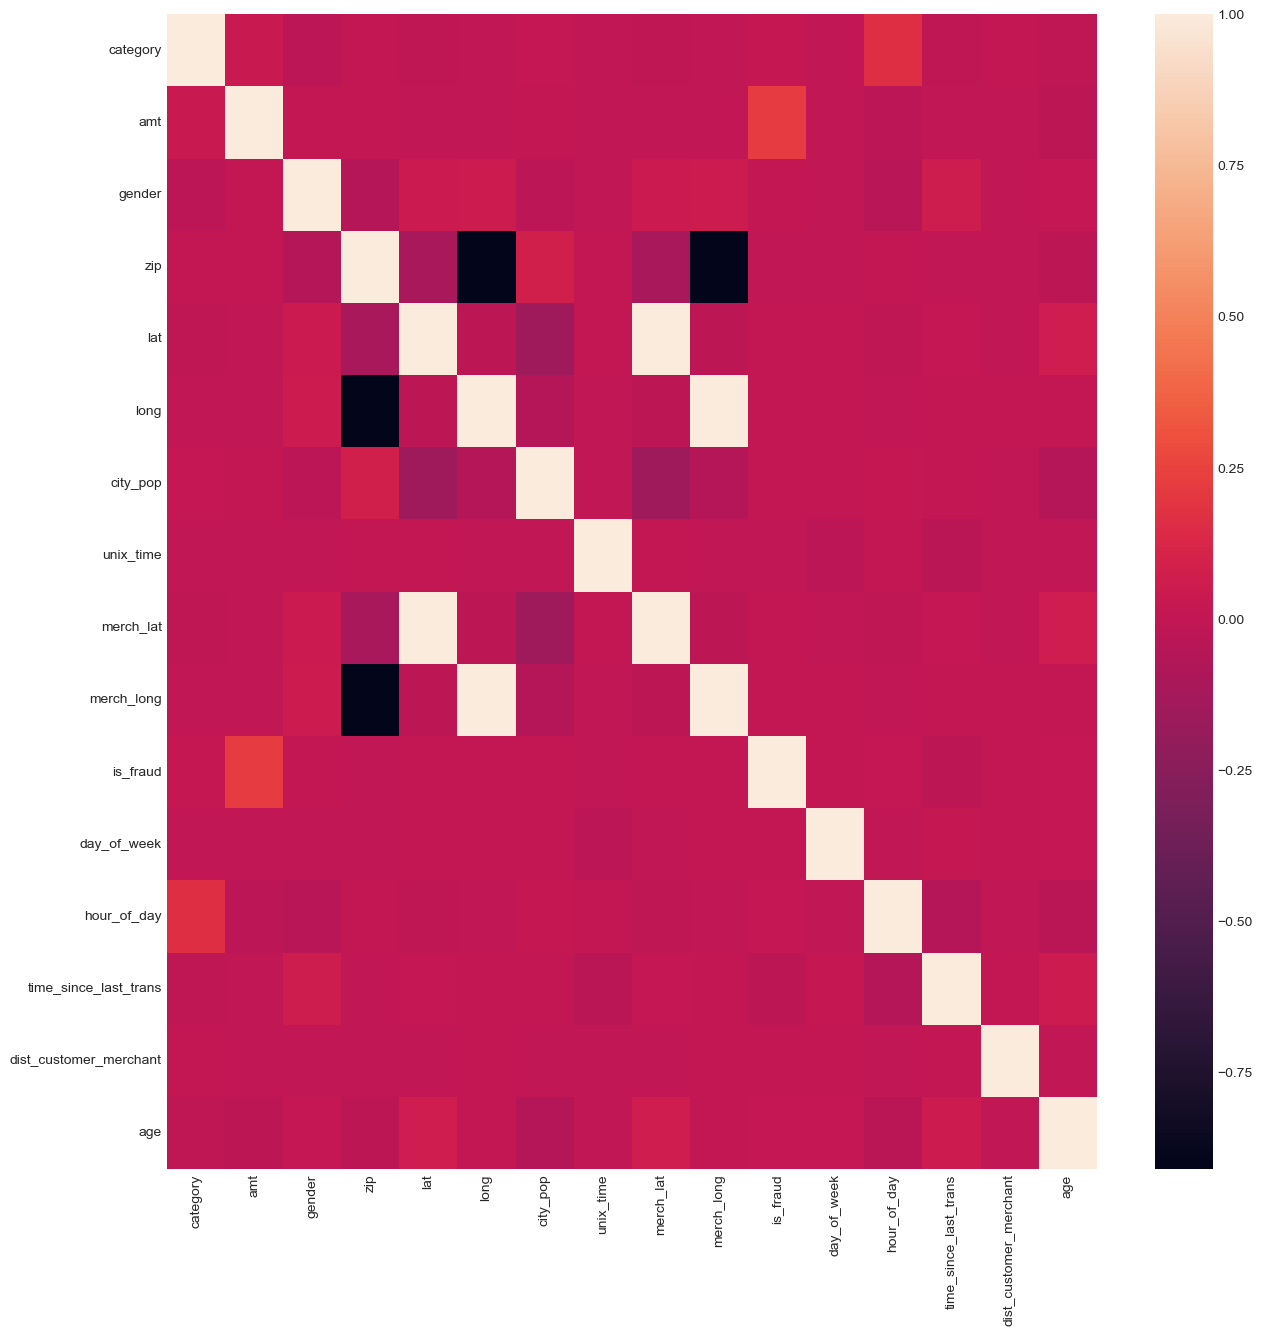

In [87]:
#let us now check the correlations between the columns
df_random_under_corr = df.corr()
#plotting the correlation heatplot
plt.figure(figsize=(15,15))
sns.heatmap(df_random_under_corr)
plt.show()

In [88]:
#function to return highly correlated column above a threshold
def correlation(dataset, threshold):
    col_corr = set() # This set stores the highly correlated columns
    corr_matrix = dataset.corr() #correlation matrix
    #traversing the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i,j] > threshold:
                colname = corr_matrix.columns[i] #selecting columns above threshold
                col_corr.add(colname) #adding columns to set
    return col_corr

In [89]:
#let us get the features with correlation above 85%
corr_features = correlation(df,0.85)
corr_features

{'merch_lat', 'merch_long'}

In [90]:
#removing unnecessary variables
df.drop(['zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat','merch_long','merchant','trans_num','trans_datetime','trans_year_month'],
            axis=1, inplace=True)

In [91]:
df.head()

,category,amt,gender,is_fraud,day_of_week,hour_of_day,time_since_last_trans,dist_customer_merchant,age
0,8,4.970000,0,0,1,0,0.000000,0.872830,0
1,4,107.230000,0,0,1,0,0.000000,0.272310,0
2,0,220.110000,1,0,1,0,0.000000,0.975845,1
3,2,45.000000,1,0,1,0,0.000000,0.919802,1
4,9,41.960000,1,0,1,0,0.000000,0.868505,0


In [124]:
#split X and Y
X = df.drop(['is_fraud'],axis=1)
y = df.is_fraud

In [125]:
X

,category,amt,gender,day_of_week,hour_of_day,time_since_last_trans,dist_customer_merchant,age
0,8,4.970000,0,1,0,0.000000,0.872830,0
1,4,107.230000,0,1,0,0.000000,0.272310,0
2,0,220.110000,1,1,0,0.000000,0.975845,1
3,2,45.000000,1,1,0,0.000000,0.919802,1
4,9,41.960000,1,1,0,0.000000,0.868505,0
...,...,...,...,...,...,...,...,...
1296670,0,15.560000,1,6,12,16781.000000,1.177732,1
1296671,1,51.700000,1,6,12,7962.000000,0.819632,0
1296672,1,105.930000,1,6,12,29074.000000,0.967541,1
1296673,1,74.900000,1,6,12,91018.000000,0.898775,0


In [93]:
#scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   category                1296675 non-null  int32  
 1   amt                     1296675 non-null  float64
 2   gender                  1296675 non-null  int32  
 3   is_fraud                1296675 non-null  int64  
 4   day_of_week             1296675 non-null  int64  
 5   hour_of_day             1296675 non-null  int64  
 6   time_since_last_trans   1296675 non-null  float64
 7   dist_customer_merchant  1296675 non-null  float64
 8   age                     1296675 non-null  int32  
dtypes: float64(3), int32(3), int64(3)
memory usage: 74.2 MB


In [95]:
#train-test split using stratified K fold
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X,y)

for train_index, test_index in skf.split(X,y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

y_train.value_counts()

0    644585
1      3753
Name: is_fraud, dtype: int64

In [96]:
lr = LogisticRegression(random_state=42)
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [97]:
#evaluating the model
model_name = 'Logistic Regression - imbalance class'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
#creating a dataframe to compare the performance of different models
model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall'])
evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993672,0.993721,0.993721,0.991080,0.000000,0.000000


In [98]:
#random under sampling using imblearn
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train,y_train)

y_rus.value_counts()

0    3753
1    3753
Name: is_fraud, dtype: int64

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.3, random_state=42, stratify=y_rus)

In [100]:
#creating a baseline linear model
lr = LogisticRegression(random_state=42)
#model
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [101]:
#predicting on imbalanced test data
test_pred=model.predict(X_test)
test_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [102]:
#printing the classification report of the model
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1126
           1       0.93      0.73      0.82      1126

    accuracy                           0.84      2252
   macro avg       0.86      0.84      0.84      2252
weighted avg       0.86      0.84      0.84      2252



In [103]:
#evaluating the model
model_name = 'Logistic Regression - with Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding calculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993672,0.993721,0.993721,0.991080,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.841073,0.840586,0.840586,0.838739,0.933333,0.733570


In [104]:
#oversampling with imblearn
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train,y_train)

y_ros.value_counts()

0    2627
1    2627
Name: is_fraud, dtype: int64

In [105]:
#train Test split
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, stratify=y_ros, random_state=42)
y_train.value_counts()

1    1839
0    1838
Name: is_fraud, dtype: int64

In [134]:
#implementing logistic regression
lr = LogisticRegression(random_state=42)
#creating model
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [107]:
test_pred = model.predict(X_test)
test_pred

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [108]:
#printing classification report
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       789
           1       0.94      0.72      0.82       788

    accuracy                           0.84      1577
   macro avg       0.86      0.84      0.84      1577
weighted avg       0.86      0.84      0.84      1577



In [109]:
#evaluating the model
model_name = 'Logistic Regression - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993672,0.993721,0.993721,0.991080,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.841073,0.840586,0.840586,0.838739,0.933333,0.733570
2,Logistic Regression - Random Over Sampling,0.842263,0.837666,0.837666,0.835463,0.938944,0.722081


In [110]:
#balancing using SMOTE method
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train.astype('float'), y_train)

y_sm.value_counts()

1    1839
0    1839
Name: is_fraud, dtype: int64

In [111]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)
y_train.value_counts()

0    1287
1    1287
Name: is_fraud, dtype: int64

In [112]:
#implementing logistic regression
lr = LogisticRegression(random_state=42)
#creating model
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [116]:
model = model.predict(X_test)
model

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [114]:
#printing classification report
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       552
           1       0.92      0.74      0.82       552

    accuracy                           0.84      1104
   macro avg       0.85      0.84      0.83      1104
weighted avg       0.85      0.84      0.83      1104



In [115]:
#evaluating the model
model_name = 'Logistic Regression - SMOTE'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993672,0.993721,0.993721,0.991080,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.841073,0.840586,0.840586,0.838739,0.933333,0.733570
2,Logistic Regression - Random Over Sampling,0.842263,0.837666,0.837666,0.835463,0.938944,0.722081
3,Logistic Regression - SMOTE,0.844211,0.836051,0.836051,0.834376,0.920635,0.735507


In [69]:
#Decisiontree classifier 
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

y_test_pred = model.predict(X_test)

print(classification_report(y_test, y_test_pred))

#evaluating the model
model_name = 'Decision Tree - imbalance class'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386718
           1       0.89      0.76      0.82      2285

    accuracy                           1.00    389003
   macro avg       0.94      0.88      0.91    389003
weighted avg       1.00      1.00      1.00    389003



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112


In [70]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

test_pred = model.predict(X_test)

print(classification_report(y_test, test_pred))

#evaluating the model
model_name = 'Decision Tree - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1128
           1       0.95      0.96      0.95      1124

    accuracy                           0.95      2252
   macro avg       0.95      0.95      0.95      2252
weighted avg       0.95      0.95      0.95      2252



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112
5,Decision Tree - Random Under Sampling,0.987438,0.954263,0.954263,0.954263,0.951370,0.957295


In [71]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

test_pred = model.predict(X_test)

print(classification_report(y_test, test_pred))

#evaluating the model
model_name = 'Decision Tree - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       795
           1       0.94      0.96      0.95       782

    accuracy                           0.95      1577
   macro avg       0.95      0.95      0.95      1577
weighted avg       0.95      0.95      0.95      1577



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112
5,Decision Tree - Random Under Sampling,0.987438,0.954263,0.954263,0.954263,0.951370,0.957295
6,Decision Tree - Random Over Sampling,0.991297,0.946100,0.946100,0.946100,0.937265,0.955243


In [72]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

test_pred = model.predict(X_test)

print(classification_report(y_test, test_pred))

#evaluating the model
model_name = 'Decision Tree - SMOTE'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       546
           1       0.95      0.93      0.94       558

    accuracy                           0.94      1104
   macro avg       0.94      0.94      0.94      1104
weighted avg       0.94      0.94      0.94      1104



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112
5,Decision Tree - Random Under Sampling,0.987438,0.954263,0.954263,0.954263,0.951370,0.957295
6,Decision Tree - Random Over Sampling,0.991297,0.946100,0.946100,0.946100,0.937265,0.955243
7,Decision Tree - SMOTE,0.994949,0.940217,0.940217,0.940217,0.950549,0.930108


In [73]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

y_test_pred = model.predict(X_test)

print(classification_report(y_test, y_test_pred))

#evaluating the model
model_name = 'Random Forest - imbalance class'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386718
           1       0.95      0.74      0.83      2285

    accuracy                           1.00    389003
   macro avg       0.98      0.87      0.92    389003
weighted avg       1.00      1.00      1.00    389003



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112
5,Decision Tree - Random Under Sampling,0.987438,0.954263,0.954263,0.954263,0.951370,0.957295
6,Decision Tree - Random Over Sampling,0.991297,0.946100,0.946100,0.946100,0.937265,0.955243
7,Decision Tree - SMOTE,0.994949,0.940217,0.940217,0.940217,0.950549,0.930108
8,Random Forest - imbalance class,0.999997,0.998257,0.998257,0.998147,0.954211,0.738731


In [74]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

test_pred = model.predict(X_test)

print(classification_report(y_test, test_pred))

#evaluating the model
model_name = 'Random Forest - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1128
           1       0.98      0.95      0.97      1124

    accuracy                           0.97      2252
   macro avg       0.97      0.97      0.97      2252
weighted avg       0.97      0.97      0.97      2252



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112
5,Decision Tree - Random Under Sampling,0.987438,0.954263,0.954263,0.954263,0.951370,0.957295
6,Decision Tree - Random Over Sampling,0.991297,0.946100,0.946100,0.946100,0.937265,0.955243
7,Decision Tree - SMOTE,0.994949,0.940217,0.940217,0.940217,0.950549,0.930108
8,Random Forest - imbalance class,0.999997,0.998257,0.998257,0.998147,0.954211,0.738731
9,Random Forest - Random Under Sampling,1.000000,0.965808,0.965808,0.965803,0.977211,0.953737


In [75]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

test_pred = model.predict(X_test)

print(classification_report(y_test, test_pred))

#evaluating the model
model_name = 'Random Forest - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       795
           1       0.97      0.94      0.95       782

    accuracy                           0.95      1577
   macro avg       0.96      0.95      0.95      1577
weighted avg       0.96      0.95      0.95      1577



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112
5,Decision Tree - Random Under Sampling,0.987438,0.954263,0.954263,0.954263,0.951370,0.957295
6,Decision Tree - Random Over Sampling,0.991297,0.946100,0.946100,0.946100,0.937265,0.955243
7,Decision Tree - SMOTE,0.994949,0.940217,0.940217,0.940217,0.950549,0.930108
8,Random Forest - imbalance class,0.999997,0.998257,0.998257,0.998147,0.954211,0.738731
9,Random Forest - Random Under Sampling,1.000000,0.965808,0.965808,0.965803,0.977211,0.953737


In [79]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

test_pred = model.predict(X_test)

print(classification_report(y_test, test_pred))

#evaluating the model
model_name = 'Random Forest - SMOTE'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       546
           1       0.95      0.95      0.95       558

    accuracy                           0.95      1104
   macro avg       0.95      0.95      0.95      1104
weighted avg       0.95      0.95      0.95      1104



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112
5,Decision Tree - Random Under Sampling,0.987438,0.954263,0.954263,0.954263,0.951370,0.957295
6,Decision Tree - Random Over Sampling,0.991297,0.946100,0.946100,0.946100,0.937265,0.955243
7,Decision Tree - SMOTE,0.994949,0.940217,0.940217,0.940217,0.950549,0.930108
8,Random Forest - imbalance class,0.999997,0.998257,0.998257,0.998147,0.954211,0.738731
9,Random Forest - Random Under Sampling,1.000000,0.965808,0.965808,0.965803,0.977211,0.953737


In [80]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

test_pred = model.predict(X_test)

print(classification_report(y_test, test_pred))

#evaluating the model
model_name = 'Random Forest - SMOTE'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       546
           1       0.95      0.95      0.95       558

    accuracy                           0.95      1104
   macro avg       0.95      0.95      0.95      1104
weighted avg       0.95      0.95      0.95      1104



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112
5,Decision Tree - Random Under Sampling,0.987438,0.954263,0.954263,0.954263,0.951370,0.957295
6,Decision Tree - Random Over Sampling,0.991297,0.946100,0.946100,0.946100,0.937265,0.955243
7,Decision Tree - SMOTE,0.994949,0.940217,0.940217,0.940217,0.950549,0.930108
8,Random Forest - imbalance class,0.999997,0.998257,0.998257,0.998147,0.954211,0.738731
9,Random Forest - Random Under Sampling,1.000000,0.965808,0.965808,0.965803,0.977211,0.953737


In [ ]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]

# Create the random grid
#grid = {'n_estimators': n_estimators,
 #              'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf
#              }

#print(grid)

In [81]:
best_grid = RandomForestClassifier(max_features = 'sqrt', n_estimators=200, random_state=42)
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.3, random_state=42)

model = best_grid.fit(X_train,y_train)

test_pred = model.predict(X_test)

print(classification_report(y_test, test_pred))

#evaluating the model
model_name = 'Random Forest - SMOTE [Hyperparameter Tuned]'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,test_pred)
f_score = f1_score(y_test, test_pred, average='weighted')
precision = precision_score(y_test, test_pred)
recall = metrics.recall_score(y_test,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       546
           1       0.96      0.95      0.95       558

    accuracy                           0.95      1104
   macro avg       0.95      0.95      0.95      1104
weighted avg       0.95      0.95      0.95      1104



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - imbalance class,0.993701,0.993747,0.993747,0.991093,0.000000,0.000000
1,Logistic Regression - with Random Under Sampling,0.836315,0.835258,0.835258,0.833685,0.916207,0.738011
2,Logistic Regression - Random Over Sampling,0.837639,0.832594,0.832594,0.830971,0.913249,0.734772
3,Logistic Regression - SMOTE,0.835276,0.841486,0.841486,0.839747,0.931350,0.737319
4,Decision Tree - imbalance class,0.998622,0.998026,0.998026,0.997946,0.890376,0.757112
5,Decision Tree - Random Under Sampling,0.987438,0.954263,0.954263,0.954263,0.951370,0.957295
6,Decision Tree - Random Over Sampling,0.991297,0.946100,0.946100,0.946100,0.937265,0.955243
7,Decision Tree - SMOTE,0.994949,0.940217,0.940217,0.940217,0.950549,0.930108
8,Random Forest - imbalance class,0.999997,0.998257,0.998257,0.998147,0.954211,0.738731
9,Random Forest - Random Under Sampling,1.000000,0.965808,0.965808,0.965803,0.977211,0.953737


In [119]:
df.columns

Index(['category', 'amt', 'gender', 'is_fraud', 'day_of_week', 'hour_of_day',
       'time_since_last_trans', 'dist_customer_merchant', 'age'],
      dtype='object')

In [121]:
!pip install twilio

     ---------------------------------------- 1.7/1.7 MB 366.0 kB/s eta 0:00:00
     ------------------------------------ 323.6/323.6 kB 911.0 kB/s eta 0:00:00
     ------------------------------------ 101.8/101.8 kB 532.1 kB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.8.3
    Uninstalling aiohttp-3.8.3:
      Successfully uninstalled aiohttp-3.8.3


In [122]:
from twilio.rest import Client

In [132]:
df.columns

Index(['category', 'amt', 'gender', 'is_fraud', 'day_of_week', 'hour_of_day',
       'time_since_last_trans', 'dist_customer_merchant', 'age'],
      dtype='object')

In [ ]:
# Send a text message alert if fraud is detected
account_sid = ''
auth_token = ''
client = Client(account_sid, auth_token)

for index, transaction in X.iterrows():
    # Extract relevant features from the transaction data
    transaction_data = np.array([[transaction['category'], transaction['gender'], transaction['amt'], transaction['day_of_week'],
                                 transaction['hour_of_day'],transaction['time_since_last_trans'],transaction['dist_customer_merchant'],transaction['age']
                                 ]])

    # Make a prediction using the trained model
    prediction = model.predict(transaction_data)

    # If fraud is detected, send a text message alert
    if prediction == 1:
        message = client.messages.create(
            body="Fraudulent transaction detected on your credit card! Please contact your bank immediately.",
            from_='',
            to=''
        )

        print(message.sid)

## Exploratory Data Analysis:

various features of the data set have been analyzed and several insights have been obtained.
The 'trans_date_trans_time' feature has been broken down into several components like 'Age', 'day of the week', 'month' in order to facilitate our analysis.

These features have been thoroughly analyzed. It has been found that most transaction are being done after 12 noon and that during holiday seasons, the number of transaction along with the number of fraudulent transactions will increase.

Old age people above 75 years are more susseptible to frauds. This is because, fraudsters might try to take advantage of their lack of knowledge about the constantly changing ways of how transactions are made.
The 'Female' gender people have been observed to do much of the transaction according to the dataset. Hence, transactions involving might be much prone to fraud.

Also, by analyzing several demographic variables like city, state, zip etc it has been found that, several places like 'DE' state has 100% fraud rate and about 50 zip codes and 70 cities have 100% fraud rate. There might be some ill practices happening at the ground level at these places since all the transactions happening there are shown as fraudulent.

Similarly, several job profiles wherein a 100% fraud rate is seen can also be checked for descripencies.
In the categories feature, gas_transport, grocery_pos, home, shopping_pos, kids_pets are the top 5 most categories with most fraud rates. Most of these categories seem to involve either an online transaction sale or a POS sale. There might be some issue on those fronts like tampered POS machines, or hacked transaction gateway which can be checked by the company.

In the Merchant category the merchants fraud_Kozey-Boehm; fraud_Herman, Treutel and Dickens have a higher than usual amount of fraudulent transactions associated with them. And hence, even they can be checked for malpractices.

## Model Building:

The features 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat','merch_long' have been asumed to provide no significant information in the model building phase. Hence, they along with the original features that have been encoded have been dropped from the dataset.

3 different algorithms have been implemented upon the processed dataset.

3 sampling techniques in order to balance the dataset have also been implemented.

The algorithms have also been implemented upon the dataset before balancing the dataset for demonstration purposes.

Hence, about 12 different models have been created the results of which have been summarized above.

Out of the 12 models that have been built, the Random Forest Classifier built using the SMOTE sampling technique after hyper parameter tuning has provided us the most preferable model with a recall of 0.99, f1 score of 0.99 and precision of 0.99.

Hence, it can be said the the Radom Forest Classifier - SMOTE sampling is the best model.